## Quick look picture

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

PIL mode: P
PIL mode: L


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_32222/4022986451.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


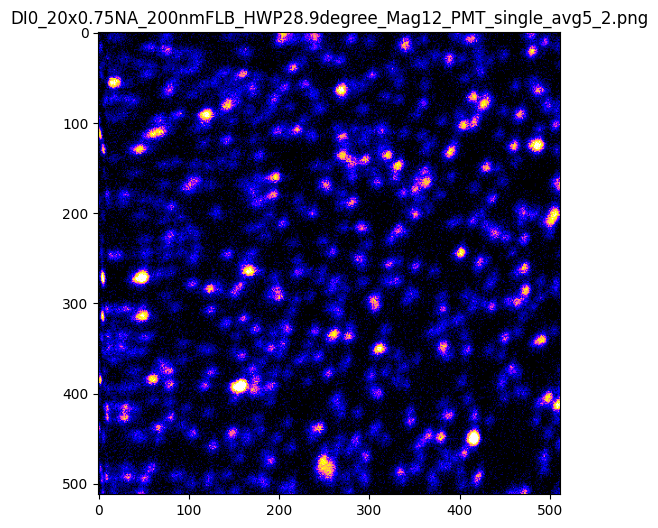

In [3]:
# open PNG image plot with matplotlib
fileDir = './4_data/trainning/200nm/'
fileName = 'DI0_20x0.75NA_200nmFLB_HWP28.9degree_Mag12_PMT_single_avg5_2.png'



img = Image.open(fileDir + fileName)
print("PIL mode:", img.mode) # mode 屬性會告訴你色彩模式

img = img.convert('L')  # convert to grayscale
print("PIL mode:", img.mode)
img_array = np.array(img)
fig1, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_array, cmap='gnuplot2')
ax.set_title(fileName)
fig1.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_32222/3907055257.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


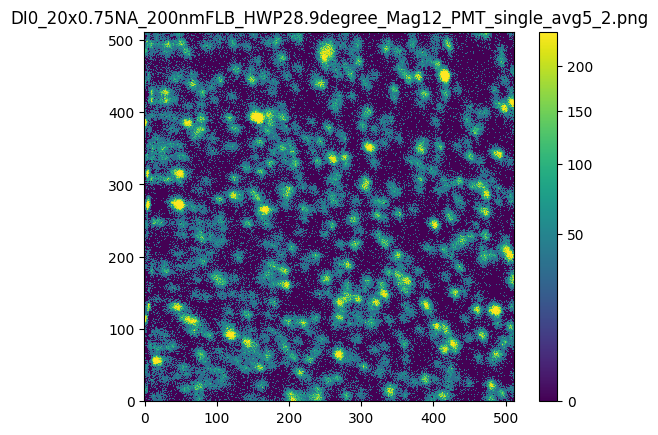

In [4]:
from vidualize import plot_picture

fig, ax = plot_picture(img_array, percent= 99.5)
ax.set_title(fileName)
fig.show()

## Background extract

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_32222/1419233777.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


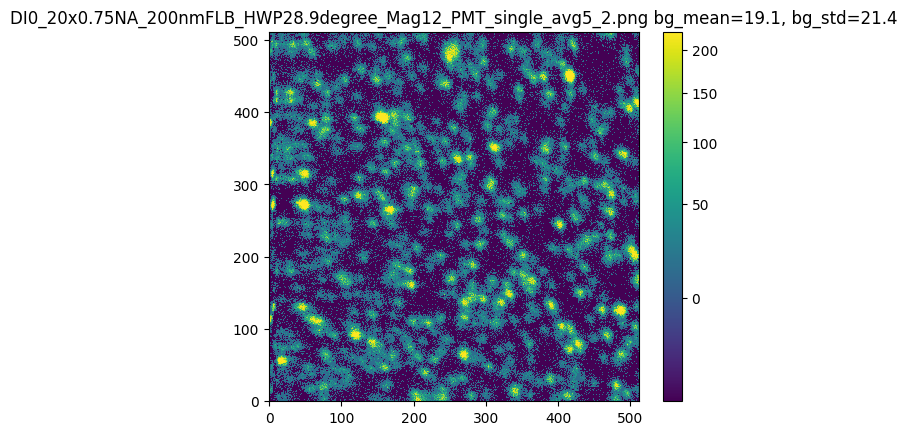

In [5]:
# viw the region that > bg_mean + kappa*std -> source
# let it be a great value to see it
from kapasigmaClip import kappaSigmaClipping

mask, bg_mean, bg_std = kappaSigmaClipping(3, 20, img_array)
image_clean_bg = img_array - bg_mean # remove background mean
fig, ax = plot_picture(image_clean_bg, percent= 99.5)
ax.set_title(fileName + f' bg_mean={bg_mean:.1f}, bg_std={bg_std:.1f}')
fig.show()


## Find source

In [6]:
from findSource import find_source, plot_source
fwhm_guss = 8.0  # guess FWHM in pixel
sources = find_source(image_clean_bg, sigma=3, fwhm=fwhm_guss, threshold_times=2)
print(f"Found {len(sources)} sources")

Found 260 sources


## Plot source hold radius

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_32222/2723434240.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


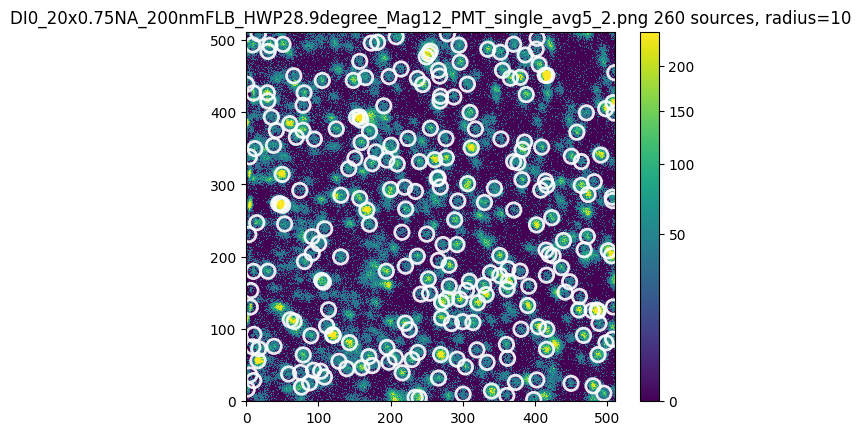

In [7]:
radius = 10
fig, ax = plot_source(img_array, sources, radius=radius, percent=99.5)
ax.set_title(f'{fileName} {len(sources)} sources, radius={radius}') 
fig.show()

## FWHMx 1D fitting
Use FWHM 2D fitting result as initioal fitting parm fit again
not sure is this is necessary, but for plot 1D fitting convenience, just fit again...

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_32222/224536790.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


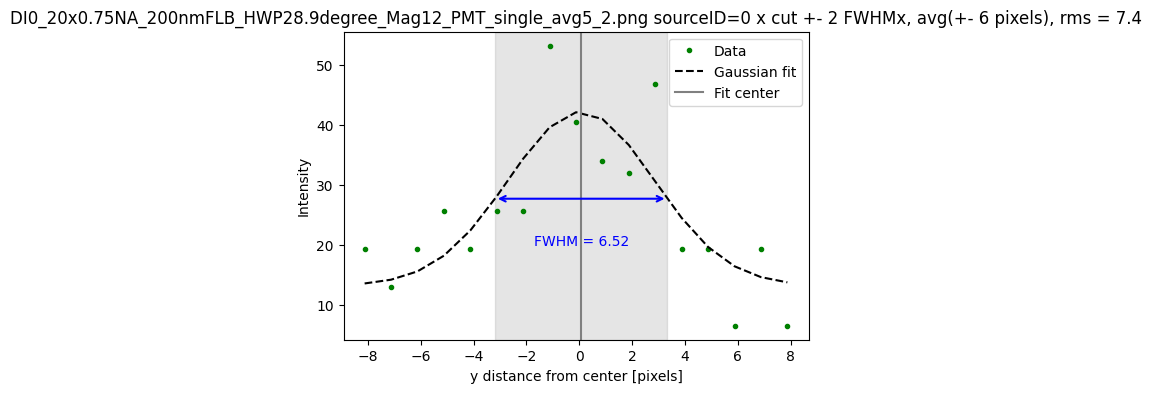

In [8]:
from fwhm1d import plot_xy_cut_gaussian
from fwhm1d import fit_gaussian_xy
avg_pixel_num = 6
sourceID = 0
axis = 'x'
sources['x_fwhm'] = fwhm_guss
sources['y_fwhm'] = fwhm_guss
parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = axis, sourceID=sourceID, avg_pixel_num=avg_pixel_num)
fig, ax = plot_xy_cut_gaussian(sources, sourceID=0, parm=parm, x_rel=main_rel_range, intensity_profile=intensity_profile, x0=x0, axis='y')
ax.set_title(f'{fileName} sourceID=0 {axis} cut +- 2 FWHMx, avg(+- {avg_pixel_num} pixels), rms = {rms:.1f}')
fig.show()

In [11]:
# for each source, plot the x cut gaussian fit and create subplots
num_sources = len(sources)
axis = 'y'
num_cols = 4
num_rows = (num_sources + num_cols - 1) // num_cols  #
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*7))
axes = axes.flatten()  # 將 2D 陣列展平為
rms_x_list = []
x_fwhm_list = []
x_fit_success_list = []

for i in range(num_sources):
    try:
        parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = 'x', sourceID=i, avg_pixel_num=avg_pixel_num)
        amp, mu, sigma, offset = parm 
        fwhm_fit = sigma * 2.355
        x_fwhm_list.append(fwhm_fit)
        x_fit_success_list.append(True)
        rms_x_list.append(rms)
    except Exception as e:
        print(f"Source ID {i} fit failed: {e}")
        x_fwhm_list.append(np.nan)
        x_fit_success_list.append(False)
        rms_x_list.append(np.nan)


sources['rms_fit_x'] = rms_x_list
sources['x_fwhm'] = x_fwhm_list
sources = sources[x_fit_success_list]  # keep only successful fits
# sort sources by rms
sources.sort('rms_fit_x')
max_plot_num = 20
for i in range(min(num_sources, max_plot_num)):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = 'x', sourceID=i, avg_pixel_num=avg_pixel_num)    
    fig, ax = plot_xy_cut_gaussian(sources, sourceID=0, parm=parm, x_rel=main_rel_range, intensity_profile=intensity_profile, x0=x0, axis='x', ax=axes[i])
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")

fig.suptitle(f'Gaussian Fits {axis} for All Sources', fontsize=40)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()  

/Users/nebula/Documents/code/Python/fwhm1d.py:65: OptimizeWarning: Covariance of the parameters could not be estimated
  parm＿optimal, parm_covarience = curve_fit(gaussian, main_rel_range, intensity_profile, p0=p0, maxfev=20000)


Source ID 54 fit failed: zero-size array to reduction operation maximum which has no identity
Source ID 117 fit failed: The number of func parameters=4 must not exceed the number of data points=3
Source ID 135 fit failed: The number of func parameters=4 must not exceed the number of data points=3
Source ID 223 fit failed: The number of func parameters=4 must not exceed the number of data points=2
Source ID 236 fit failed: The number of func parameters=4 must not exceed the number of data points=2
Source ID 242 fit failed: The number of func parameters=4 must not exceed the number of data points=3
Source ID 251 fit failed: Improper input: func input vector length N=4 must not exceed func output vector length M=1
Source ID 255 fit failed: zero-size array to reduction operation maximum which has no identity


/Users/nebula/Documents/code/Python/fwhm1d.py:65: OptimizeWarning: Covariance of the parameters could not be estimated
  parm＿optimal, parm_covarience = curve_fit(gaussian, main_rel_range, intensity_profile, p0=p0, maxfev=20000)
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_32222/3238006709.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/750431953.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


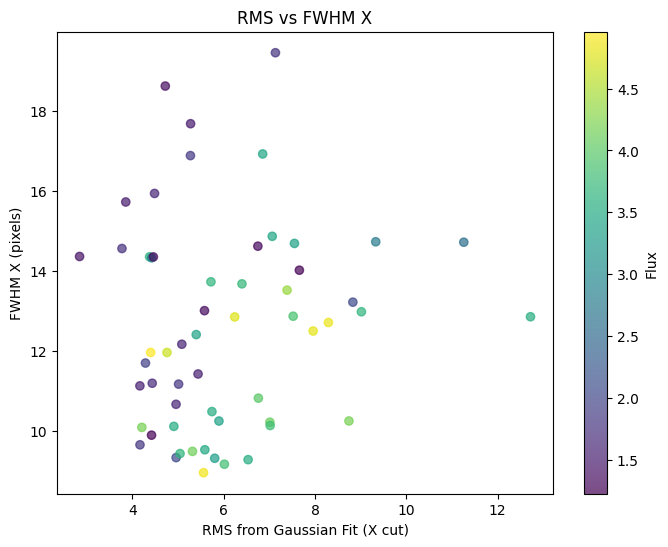

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['rms_fit_x'], sources['x_fwhm'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('RMS from Gaussian Fit (X cut)')
ax.set_ylabel('FWHM X (pixels)')
ax.set_title('RMS vs FWHM X')
# let x y scale same

fig.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/313886698.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


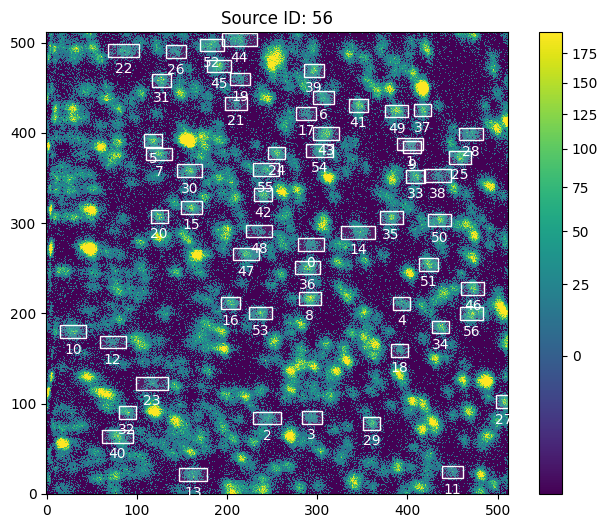

In [ ]:
import matplotlib.patches as patches

source_id = 1
fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(sources)):
    source_id = i
    x0, y0, x_half_range, y_half_range = sources[source_id]['xcentroid'], sources[source_id]['ycentroid'], sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    ax.add_patch(rect)
    ax.set_title('Source ID: {}'.format(source_id))
    fig1.show()

## FWHMy 1D fitting

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/3784661397.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


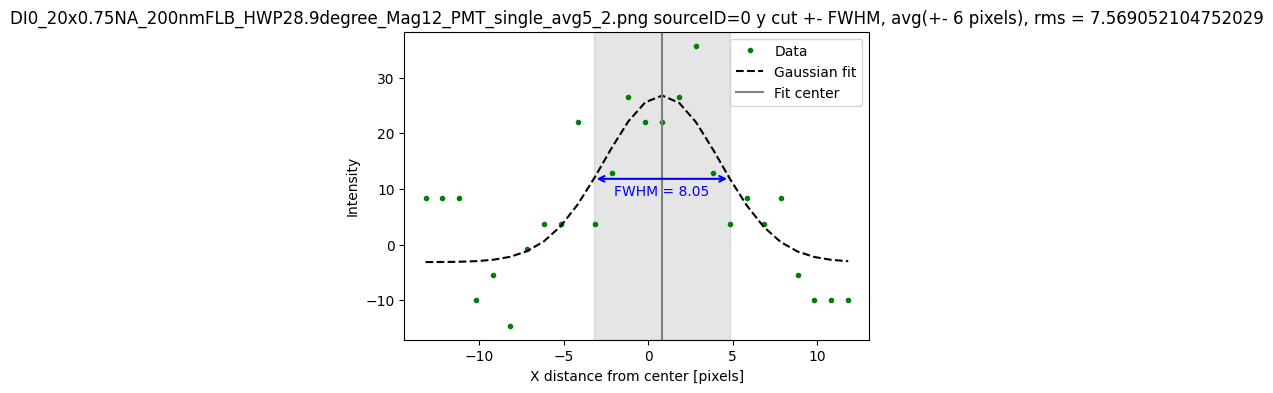

In [ ]:
from fwhm1d import plot_xy_cut_gaussian
from fwhm1d import fit_gaussian_xy
avg_pixel_num = 6
sourceID = 0
axis = 'y'
parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = axis, sourceID=sourceID, avg_pixel_num=avg_pixel_num)
fig, ax = plot_xy_cut_gaussian(sources, sourceID=sourceID, parm=parm, x_rel=main_rel_range, intensity_profile=intensity_profile, x0=x0, axis='y')
ax.set_title(f'{fileName} sourceID={sourceID} {axis} cut +- FWHM, avg(+- {avg_pixel_num} pixels), rms = {rms}')
fig.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/3840186464.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


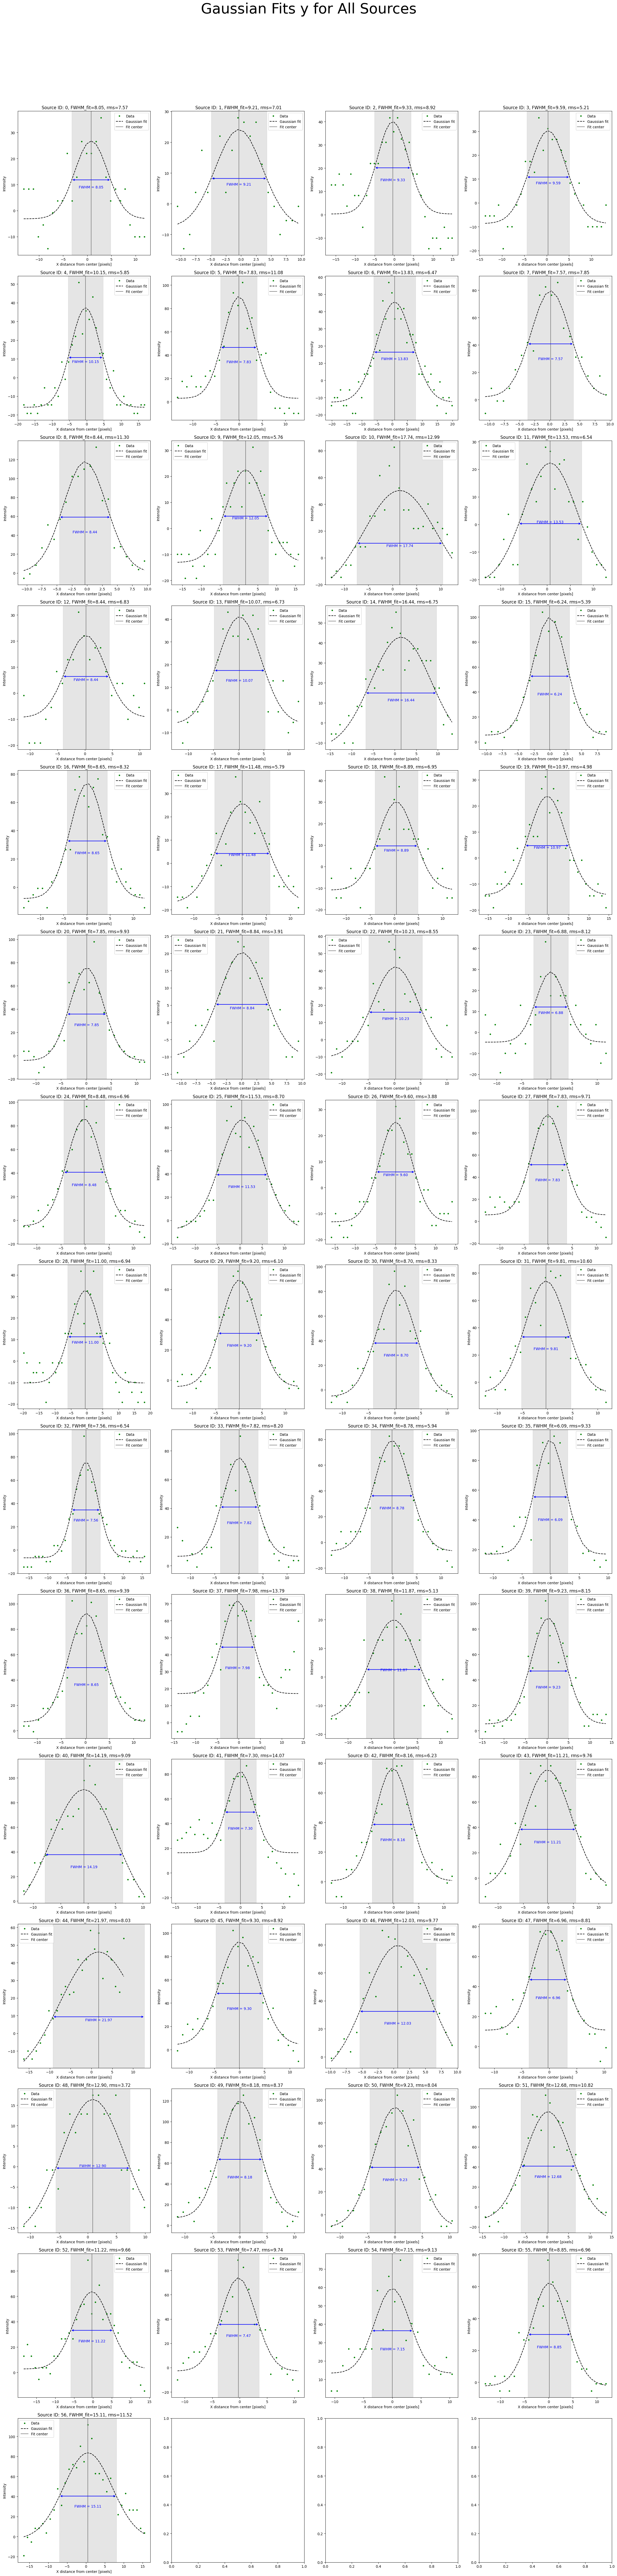

In [ ]:
# for each source, plot the x cut gaussian fit and create subplots
num_sources = len(sources)
axis = 'y'
num_cols = 4
num_rows = (num_sources + num_cols - 1) // num_cols  #
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*7))
axes = axes.flatten()  # 將 2D 陣列展平為
rms_y_list = []

for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = axis, sourceID=i, avg_pixel_num=avg_pixel_num)
    rms_y_list.append(rms)


sources['rms_fit_y'] = rms_y_list

for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = axis, sourceID=i, avg_pixel_num=avg_pixel_num)    
    fig, ax = plot_xy_cut_gaussian(sources, sourceID=0, parm=parm, x_rel=main_rel_range, intensity_profile=intensity_profile, x0=x0, axis=axis, ax=axes[i])
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")

fig.suptitle(f'Gaussian Fits {axis} for All Sources', fontsize=40)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()  

## FWHM calculation

In [ ]:
# mag = 12, 12141 pixel/mm
mag = 12
pixel_len = 1000 / 12141 # um <- measured
img_dim = 512
FOV_cut = pixel_len * img_dim
print(f"Pixel size: {pixel_len:.2f} um")
print(f"FOV: {FOV_cut * mag:.2f} um")
fwhm_x = np.average(source_cleaned['x_fwhm'])*pixel_len # um
fwhm_y = np.average(source_cleaned['y_fwhm'])*pixel_len #
print(f"Average FWHM X: {fwhm_x:.2f} um, {np.average(source_cleaned['x_fwhm'])} pixels")
print(f"Average FWHM Y: {fwhm_y:.2f} um, {np.average(source_cleaned['y_fwhm'])} pixels")

Pixel size: 0.08 um
FOV: 506.05 um
Average FWHM X: 1.04 um, 12.575068722315915 pixels
Average FWHM Y: 1.06 um, 12.879602297368498 pixels


In [ ]:

FOV = 510.6 # um <- theory FOV
Mag = 12
img_dim = 512
pixel_len = FOV/(Mag*img_dim) # um
print(f"Pixel size: {pixel_len:.2f} um")
fwhm_x = np.average(source_cleaned['x_fwhm'])*pixel_len # um
fwhm_y = np.average(source_cleaned['y_fwhm'])*pixel_len #
print(f"Average FWHM X: {fwhm_x:.2f} um, {np.average(source_cleaned['x_fwhm'])} pixels")
print(f"Average FWHM Y: {fwhm_y:.2f} um, {np.average(source_cleaned['y_fwhm'])} pixels")

Pixel size: 0.08 um
Average FWHM X: 1.05 um, 12.575068722315915 pixels
Average FWHM Y: 1.07 um, 12.879602297368498 pixels


In [ ]:
wave_len = 920 # nm
# arctan(d/2f) d: 光斑直徑 f 物鏡焦距 <- theta
# NA = n*sin(theta)
d = 8.5 # mm
f = 180/20 # mm
n = 1.0 # air
theta = np.arctan(d/(2*f)) # rad
NA = n * np.sin(theta)
print(f"Numerical Aperture NA: {NA:.3f}")
# NA = 0.75
theory_fwhm = 0.32 * wave_len / (np.sqrt(2)*NA)
print(f"Theory FWHM: {theory_fwhm:.2f} nm")

Numerical Aperture NA: 0.427
Theory FWHM: 487.52 nm


In [ ]:
# import numpy as np
# FWHM_PSF = 274.69  # nm
# FWHM_bead = 1000    # nm
# FWHM_total = np.sqrt(FWHM_PSF**2 + FWHM_bead**2)
# print(f"預期觀察到的 FWHM: {FWHM_total:.2f} nm")

## Violin plot of FWHM x y 1D fit

(0.596078431372549, 0.4486274509803921, 0.2650980392156862)
(0.44392156862745114, 0.5309803921568628, 0.5599999999999999)


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/1206580400.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FWHM X', 'FWHM Y'])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/1206580400.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


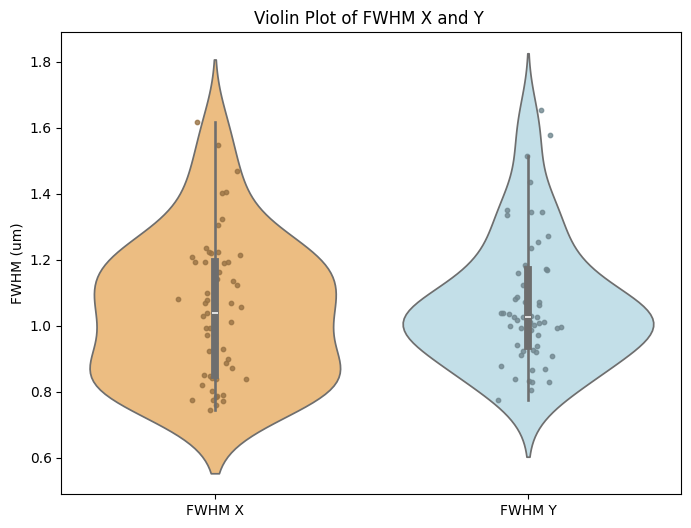

In [ ]:
# violin plot of FWHM x y 1D fit, plot all sources as dot
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('RdYlBu', n_colors=2)
data = [sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM X', 'FWHM Y'])
ax.set_ylabel('FWHM (um)')

pixel_len = FOV/(Mag*img_dim) # um

for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    print(dark_color)
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)

ax.set_title('Violin Plot of FWHM X and Y ')
fig.show()

In [ ]:
# select mean(fwhm) +- factor*std => let meam +- > factor*std be outlier
factor = 2
fwhm_x_mean = np.mean(sources['x_fwhm'])
fwhm_x_std = np.std(sources['x_fwhm'])
fwhm_y_mean = np.mean(sources['y_fwhm'])
fwhm_y_std = np.std(sources['y_fwhm'])

mask_x = (sources['x_fwhm'] > (fwhm_x_mean - factor*fwhm_x_std)) & (sources['x_fwhm'] < (fwhm_x_mean + factor*fwhm_x_std))
mask_y = (sources['y_fwhm'] > (fwhm_y_mean - factor*fwhm_y_std)) & (sources['y_fwhm'] < (fwhm_y_mean + factor*fwhm_y_std))
mask = mask_x & mask_y
source_cleaned = sources[mask]


NameError: name 'pixel_len' is not defined

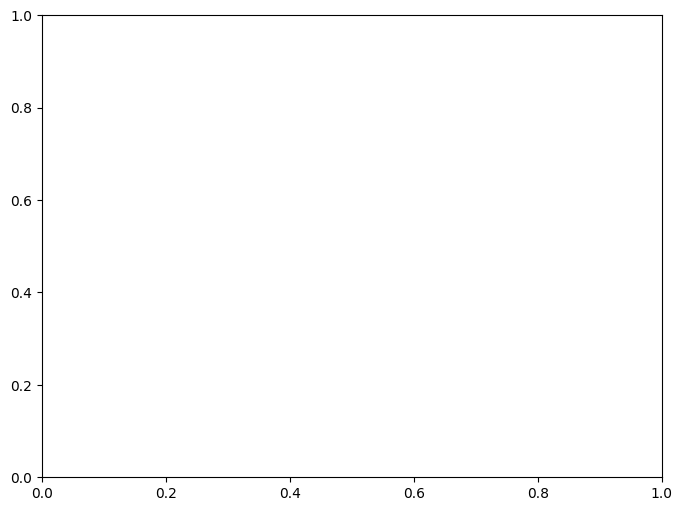

In [ ]:
# violin plot of FWHM x y 1D fit, plot all sources as dot
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('RdYlBu', n_colors=2)
data = [source_cleaned['x_fwhm']*pixel_len, source_cleaned['y_fwhm']*pixel_len]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM X', 'FWHM Y'])
ax.set_ylabel('FWHM (um)')
# calculate mean and std
mean_y_fwhm_pixel = np.mean(source_cleaned['y_fwhm']*pixel_len)
mean_x_fwhm_pixel = np.mean(source_cleaned['x_fwhm']*pixel_len)
std_y_fwhm_pixel = np.std(source_cleaned['y_fwhm']*pixel_len)
std_x_fwhm_pixel = np.std(source_cleaned['x_fwhm']*pixel_len)
print(f"Cleaned FWHM X: {mean_x_fwhm_pixel:.2f} +- {std_x_fwhm_pixel:.2f} um")
print(f"Cleaned FWHM Y: {mean_y_fwhm_pixel:.2f} +- {std_y_fwhm_pixel:.2f} um")
for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)
for i in range(len(data)):
    mean_val = np.mean(data[i])
    ax.scatter(i, mean_val, color='black', s=50, marker='.', zorder=10, label='Mean' if i == 0 else "")

ax.set_title(f'$FWHM_x$ and $FWHM_y$')
fig.show()

2